# MTH 651: Advanced Numerical Analysis

## Lecture 10

### Topics

* Discrete variational problems and SPD matrices

#### Variational Formulation for $L^2$ Projection

We saw how to use MFEM to compute interpolants to approximate functions.

Let's look at another way of approximating an arbitrary function.

Let $f \in L^2(\Omega)$.

We want to find $u_h \in V_h$ such that
$$
    \| u_h - f \|_{L^2(\Omega)} = \min_{v \in V_h} \| v - f \|_{L^2(\Omega)}.
$$

How can we use the ideas of **variational formulations** and **Galerkin orthogonality** to find such a $u_h$?

First of all, why did we write $\min$ instead of $\inf$?

In other words, why do we know that a minimizer exists?

Define the bilinear form $m(\cdot, \cdot)$ by
$$
    m(u, v) = (u, v)
$$
i.e. $m(\cdot, \cdot)$ is just the standard $L^2$ inner product.

Let $f \in L^2(\Omega)$ be given.

> Find $u_h \in V_h$ such that
> $$ m(u_h, v) = (f, v) $$
> for all $v \in V_h$.

> **_PROPOSITION:_** (Galerkin orthogonality). The error $u_h - f$ is orthogonal (in the $L^2$ inner product) to all of $V_h$

> _Proof._ 
> $$
>   (u_h - f, v) = (u_h, v) - (f, v) = 0.
> $$

> **_PROPOSITION:_** $\| u_h - f \|_{L^2(\Omega)} = \min_{v \in V_h} \| v - f \|_{L^2(\Omega)}$.

> _Proof._ This is a consequence of Galerkin orthogonality.

We should notice that all of the above results are **completely analogous** to those that we have shown previously for the variational form of the Poisson problem.
(In fact, we proved the more abstract version for any coercive and continuous bilinear form — the form $m(\cdot, \cdot)$ is trivially coercive and continuous with constants 1).

The bilinear form $m(\cdot, \cdot)$ induces an **associated system matrix**.

Let $\phi_i$ denote the global basis functions.

Define the **mass matrix**

$$
    M_{ij} = m(\phi_i, \phi_j)
$$

Define the vector $F$ by

$$
    F_i = (f, v_i)
$$

Then, the variational problem is equation to the following linear system of equations

$$
    M U = F
$$

where the vector $U$ represents the coefficients of $u_h$ expanded in the basis $\phi_i$.

In [2]:
# Import MFEM and GLVis, define a coefficient...

import mfem.ser as mfem
from glvis import glvis

from math import cos, exp, sin

class f(mfem.PyCoefficient):
    def EvalValue(self, xvec):
        x = xvec[0]
        y = xvec[1]
        return exp(0.1*sin(5.1*x - 6.2*y) + 0.3*cos(4.3*x +3.4*y))

In [5]:
# Create the mesh and finite element space
mesh = mfem.Mesh(10, 10, "TRIANGLE")
order_k = 2
fe_collection = mfem.H1_FECollection(order_k, mesh.Dimension())
fe_space = mfem.FiniteElementSpace(mesh, fe_collection)

# 5. Define the solution x as a finite element grid function in fespace. Set
#    the initial guess to zero, which also sets the boundary conditions.
u = mfem.GridFunction(fe_space)

# Create the right-hand side vector using the linear form F : v -> (f, v)
# This is called a "domain linear form integrator", or DomainLFIntegrator
F = mfem.LinearForm(fe_space)
F.AddDomainIntegrator(mfem.DomainLFIntegrator(f()))
# F.Assemble() tells MFEM to actually compute the entries of the vector F
F.Assemble()

# Set up the bilinear form m(.,.). The L2 inner product is called a
# "mass integrator"
m = mfem.BilinearForm(fe_space)
m.AddDomainIntegrator(mfem.MassIntegrator())
m.Assemble()
m.Finalize()

# Get the matrix associated with the bilinear form
M = m.SpMat()


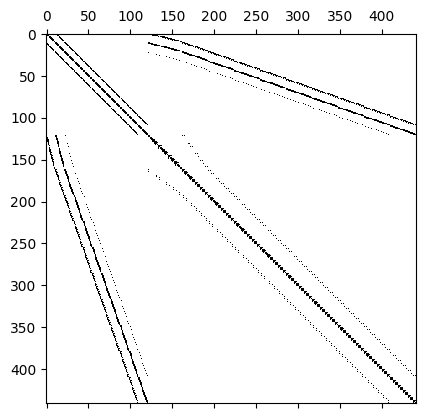

In [4]:
from mfem.common.sparse_utils import sparsemat_to_scipycsr
import matplotlib.pyplot as plt

plt.spy(sparsemat_to_scipycsr(M, float).todense())

In [5]:
GS = mfem.GSSmoother(M)
u.Assign(0.0)
mfem.PCG(M, GS, F, u, 1, 200, 1e-12, 0.0)

   Iteration :   0  (B r, r) = 0.815589
   Iteration :   1  (B r, r) = 0.00608633
   Iteration :   2  (B r, r) = 9.05023e-05
   Iteration :   3  (B r, r) = 1.09097e-06
   Iteration :   4  (B r, r) = 2.09921e-08
   Iteration :   5  (B r, r) = 3.86382e-10
   Iteration :   6  (B r, r) = 4.0508e-12
   Iteration :   7  (B r, r) = 2.82838e-14
Average reduction factor = 0.109289


In [6]:
glvis((mesh, u))

glvis(data_str='MFEM mesh v1.0\n\n#\n# MFEM Geometry Types (see mesh/geom.hpp):\n#\n# POINT       = 0\n# SEGME…

### Properties of the mass matrix

First, $M$ is symmetric. (Why?)

> **_DEFINITION:_** A symmetric matrix $A$ is called **positive definite** if
>
> * $v^T A v \geq 0$ for all $v$
> * $v^T A v = 0$ only when $v = 0$
>
> If only the first condition holds, the matrix is called **positive semidefinite**

> **_PROPOSITION:_** $M$ is positive definite. (Why)?

> **_PROPOSITION:_** A symmetric matrix $A$ is positive definite iff all of its eigenvalues are positive.

First, we should recall that a symmetric matrix (Hermetian, even) has only real eigenvalues.

To see this, suppose $A^* = A$, and let $A v = \lambda v$.
Then, $v^* A v = \lambda v^* v = \lambda \| v \|^2$, and
$$
    \lambda^* \| v \|^2 = (v^* A v)^* = v^* A^* v = v^* A v = \lambda \| v \|^2,
$$
so $\lambda = \lambda^*$ and $\lambda \in \mathbb{R}$.

Now, suppose $A$ is positive definite.
Let $v$ be an eigenvector.
Then,
$$
    0 < v^T A v = \lambda \| v \|^2,
$$
so $\lambda > 0$.

Now, suppose that $A$ has only positive eigenvalues.
Then, by the spectral theorem,
$$
    A = Q^T \Lambda Q,
$$
where $Q$ is orthogonal (i.e. $Q^T = Q^{-1}$), and $\Lambda = \operatorname{diag}(\lambda_1, \lambda_2, \ldots, \lambda_n)$.
Then, for any $v$, let $w = Q v$, i.e. $v = Q^{-1} w$.
So,
$$
    v^T A v = (Q^{-1} w)^T A Q^{-1} w = w^T Q^{-T} Q^T \Lambda Q Q^{-1} w = w^T \Lambda w > 0
$$

The fact that $M$ is SPD (symmetric and positive definite) makes the linear system of equations
$$
    M U = F
$$
much easier to solve.
Such systems are more amenable to solution by numerical methods, both direct and iterative.
In particular,

* Direct: can use Cholesky instead of LU
* Iterative:
    * Gauss-Seidel
    * (Better:) (preconditioned) conjugate gradient

#### Gauss-Seidel method

Let $A$ be a given matrix.
We want to solve
$$
    A x = b
$$
for some right-hand side $b$.
Suppose we cannot invert $A$ (e.g. because it is too large)

Decompose $A = L + U$, where

* $L$ is lower-triangular
* $U$ is **strictly** upper-triangular (zeros on the diagonal)

The main idea is to approximate $A$ by its lower-triangular part (we could equally well use the upper-triangular part --- in our case, the matrix is symmetric, so it doesn't matter).

We start with an initial guess $x^{(0)}$.
This guess is not in general exact, so we have some **residual**
$$
    r^{(0)} = b - A x^{(0)}
$$

**If** we could invert $A$, and solve for the **error**
$$
    e^{(0)} = A^{-1} r^{(0)}
$$
then we can check
$$
    x = x^{(0)} + e^{(0)}
$$
since
$$
    A (x^{(0)} + e^{(0)}) = A x^{(0)} + r^{(0)} = b.
$$

But, we can approximate $e^{(0)}$ using the lower-triangular part $L$, and then iterate, i.e.
$$
    x^{(1)} = x^{(0)} + L^{-1} r^{(0)}
$$
We can see that this iteration results in
$$
    x^{(1)} = L^{-1} ( b - U x^{(0)} ).
$$
Another way of obtaining the same iteration is to write
$$
    Ax = (L + U) x = b
$$
and split the left-hand side to get
$$
    Lx = b - Ux,
$$
and use the "previous" guess for the right-hand side.

In general, the iteration is
$$
    x^{(i+1)} = L^{-1} ( b - Ux^{(i)})
$$

This can be viewed as a **fixed-point iteration**, let $\Phi$ be the iteration operator, i.e.
$$
    \Phi(v) = L^{-1}(b - Ux).
$$
It is easy to see that a **fixed point** of $\Phi$ is a solution to $A x = b$.

The iteration has a unique fixed point if $\Phi$ is a contraction mapping, i.e. if the iteration matrix $\| -L^{-1} U \| < 1$ in some (any!) norm.

(Note that $-L^{-1} U = -L^{-1} (A - L) = I - L^{-1} A$).

Another way of seeing this is to consider the error at step $i+1$

$$
\begin{aligned}
    e^{(i+1)} &= x^{(i+1)} - x \\
        &= L^{-1}(b - Ux^{(i)}) - x \\
        &= L^{-1}(b - (A - L)x^{(i)}) - x \\
        &= L^{-1}b - L^{-1} A x^{(i)} + x^{(i)} - x \\
        &= L^{-1} A x - L^{-1} A x^{(i)} + x^{(i)} - x \\
        &= (I - L^{-1} A)(x^{(i)} - x) \\
        &= (I - L^{-1} A)(e^{(i)}) \\
\end{aligned}
$$

and so

$$
    e^{(i+1)} = (I - L^{-1} A)^{i+1} e^{(0)}
$$

hence

$$
    \| e^{(i+1)} \| \leq \| I - L^{-1} A \|^{i+1}  \| e^{(0)} \|
$$
in **any** norm

Now, we want to show that $I - L^{-1} A$ has norm less than one.

First, we note that if $A$ is SPD, then $A$ induces a norm
$$
    \| x \|_A^2 = x^T A x.
$$

Then, consider the norm of $\| I - L^{-1} A \|_A$.
The statement $\| I - L^{-1} A \|_A < 1$ is equivalent to
$$
    ((I - L^{-1}A)x)^T A ((I - L^{-1}A) x) < x^T A x
$$
for all $x$, or
$$
    x^T A x - ((I - L^{-1}A)x)^T A ((I - L^{-1}A) x) > 0.
$$
Expanding
$$
    \begin{aligned}
        x^T A x - (x^T - x^T A L^{-T}) A (x - L^{-1}A x) 
            &= x^T A x - x^T (I - A L^{-T}) A (I - L^{-1}A ) x \\
            &= x^T A x - x^T (A - A L^{-T} A) (I - L^{-1}A ) x \\
            &= x^T A x - x^T (A - A L^{-T} A - A L^{-1}A + A L^{-T} A L^{-1}A ) x \\
            &= x^T (A L^{-T} A + A L^{-1}A - A L^{-T} A L^{-1}A ) x \\
            &= x^T A^T (L^{-T} + L^{-1} - L^{-T} A L^{-1} ) A x \\
            &= x^T A^T L^{-T} (L + L^T - A ) L^{-1} A x
    \end{aligned}
$$
If $L + L^T - A$ is SPD, then the inequality holds.

Note that $L + L^T - A$ is the diagonal of $A$, and if $A$ is SPD, then it's diagonal must also be SPD.

So, the inequality holds, and we conclude that Gauss-Seidel converges when applied to **any** SPD matrix.

In MFEM, this class of fixed-point iteration solvers are called "simple linear iterations" or "stationary linear iterations" (SLI).

The general form is

$$
    x^{(i+1)} = x^{(i)} + B (b - Ax^{(i)}),
$$

so for Gauss-Seidel this is given by $B = L^{-1}$.

In [11]:
Linv = mfem.GSSmoother(M)
GS = mfem.SLISolver()
GS.SetPreconditioner(Linv)
GS.SetOperator(M)
GS.SetRelTol(1e-10)
GS.SetPrintLevel(1)
GS.SetMaxIter(100)
u.Assign(0.0)
GS.Mult(F, u)

   Iteration :   0  ||Br|| = 16.4706
   Iteration :   1  ||Br|| = 4.17504    	Conv. rate: 4.17504
   Iteration :   2  ||Br|| = 0.972993   	Conv. rate: 0.23305
   Iteration :   3  ||Br|| = 0.250039   	Conv. rate: 0.256979
   Iteration :   4  ||Br|| = 0.0715647  	Conv. rate: 0.286214
   Iteration :   5  ||Br|| = 0.0223152  	Conv. rate: 0.311819
   Iteration :   6  ||Br|| = 0.00739563 	Conv. rate: 0.331417
   Iteration :   7  ||Br|| = 0.00255459 	Conv. rate: 0.345418
   Iteration :   8  ||Br|| = 0.000907271	Conv. rate: 0.355154
   Iteration :   9  ||Br|| = 0.000328322	Conv. rate: 0.361878
   Iteration :  10  ||Br|| = 0.000120338	Conv. rate: 0.366523
   Iteration :  11  ||Br|| = 4.44933e-05	Conv. rate: 0.369738
   Iteration :  12  ||Br|| = 1.65503e-05	Conv. rate: 0.371973
   Iteration :  13  ||Br|| = 6.18221e-06	Conv. rate: 0.37354
   Iteration :  14  ||Br|| = 2.31621e-06	Conv. rate: 0.374657
   Iteration :  15  ||Br|| = 8.69665e-07	Conv. rate: 0.375469
   Iteration :  16  ||Br|| = 3.27063